# Импорты

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 2.3 MB/s eta 0:00:00


In [48]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm

# Decision Tree

In [35]:
class DTNode:
    tree = None

    def __init__(self, X, Y, feature, feature_value, max_label):
        self.X = X
        self.Y = Y
        self.feature = feature
        self.feature_value = feature_value
        self.max_label = max_label
        self.left_node = None
        self.right_node = None


class DecisionTree:
    tree = None
    depth = 0

    def __init__(self, max_depth=None, gain="entropy", min_gain=0.0, min_leaves=1):
        self.max_depth = max_depth
        self.gain = gain
        self.min_gain = min_gain
        self.min_leaves = min_leaves

    def fit(self, X, Y):
        count_y = len(np.unique(Y))

        self.tree = self.__create_tree(X, Y)

    def predict(self, X):
        Y_pred = []
        for i in range(len(X)):
            node = self.tree
            curr_y_pred = None
            while node is not None:
                curr_y_pred = node.max_label
                if X[i, node.feature] < node.feature_value:
                    node = node.left_node
                else:
                    node = node.right_node
            Y_pred.append(curr_y_pred)
        return Y_pred

    def __create_tree(self, X, Y):
        if self.max_depth is not None and self.depth > self.max_depth:
            return None

        best_feature, best_feature_value, best_left_idx, best_right_idx, gain = self.__choose_best_split(X, Y)
        max_label = max(Y)

        curr_node = DTNode(X, Y, best_feature, best_feature_value, max_label)

        if gain < self.min_gain:
            return curr_node
        if len(best_left_idx) < self.min_leaves or len(best_right_idx) < self.min_leaves:
            return curr_node

        self.depth += 1
        curr_node.left_node = self.__create_tree(X[best_left_idx], Y[best_left_idx])
        curr_node.right_node = self.__create_tree(X[best_right_idx], Y[best_right_idx])

        return curr_node

    def __choose_best_split(self, X, Y):
        max_gain = -100000000000
        best_feature = None
        best_feature_value = None
        best_left_idx = None
        best_right_idx = None

        for i in range(X.shape[-1]):
            all_values = np.unique(X[:, i])
            for curr_feature_value in all_values:
                left_idx = np.where(X[:, i] <= curr_feature_value)[0]
                right_idx = np.where(X[:, i] > curr_feature_value)[0]
                curr_gain = self.__branch_criterion(Y, left_idx, right_idx)
                if curr_gain > max_gain:
                    max_gain = curr_gain
                    best_feature = i
                    best_feature_value = curr_feature_value
                    best_left_idx = left_idx
                    best_right_idx = right_idx
        return best_feature, best_feature_value, best_left_idx, best_right_idx, max_gain

    def __branch_criterion(self, Y, left_idx, right_idx):
        gain = self.__gain(Y)
        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0
        subsets_gain = len(left_idx) / len(Y) * self.__gain(Y[left_idx]) + \
                       len(right_idx) / len(Y) * self.__gain(Y[right_idx])
        return gain - subsets_gain

    def __gain(self, y):
        if self.gain == "entropy":
            return self.__entropy(y)
        elif self.gain == "gini":
            return self.__gini_gain(y)
        else:
            raise ValueError('''The introduced gain does not exist or is not implemented in this class.
                        Select one of the following gains: entropy or gini''')

    @staticmethod
    def __entropy(y):
        probabilities = np.bincount(y) / len(y)
        return sum([-p * np.log2(p) for p in probabilities if p > 0])

    @staticmethod
    def __gini_gain(y):
        probabilities = np.bincount(y) / len(y)
        return 1 - sum([p ** 2 for p in probabilities])

    def get_depth(self):
        return self.depth

# Random Forest

In [4]:
class RandomForest:
    trees = []

    def __init__(self, n_trees=10, max_features="sqrt", max_depth=None, gain="entropy", min_gain=0.0, min_leaves=1):
        self.n_trees = n_trees
        self.max_features = max_features
        self.max_depth = max_depth
        self.gain = gain
        self.min_gain = min_gain
        self.min_leaves = min_leaves

    def fit(self, X, Y):
        for i in range(self.n_trees):
            tree = DecisionTree(
                max_depth=self.max_depth,
                gain=self.gain,
                min_gain=self.min_gain,
                min_leaves=self.min_leaves
            )

            n_objects = X.shape[0]
            indices = np.random.choice(n_objects, size=n_objects, replace=True)
            X_sample, Y_sample = X[indices], Y[indices]

            n_features = X.shape[1]
            feature_indices = np.random.choice(n_features, size=int(self.__max_features(n_features)), replace=False)
            X_sample = X[:, feature_indices]

            tree.fit(X_sample, Y_sample)

            self.trees.append(tree)

    def predict(self, X):
        tree_predicts = np.array([tree.predict(X) for tree in self.trees])
        return mode(tree_predicts, axis=0).mode

    def __max_features(self, n):
        if self.max_features == "sqrt":
            return np.sqrt(n)
        elif self.max_features == "log":
            return np.log2(n)
        else:
            raise ValueError('''The introduced gain does not exist or is not implemented in this class.
                        Select one of the following gains: sqrt or log''')

# Обработка данных

In [6]:
df = pd.read_csv("processed_data.tsv", sep='\t')

X = df.drop(columns=['Система размораживания холодильной камеры', 'Название'], axis=1)
Y = df['Система размораживания холодильной камеры']

y_values = df['Система размораживания холодильной камеры'].drop_duplicates().tolist()

y_map = {i: y_values.index(i) for i in y_values}

for i in range(len(df)):
    Y.at[i] = y_map[Y[i]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21,
                                                    stratify=df['Система размораживания холодильной камеры'])
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=21)

Y_train = Y_train.astype(int)
Y_val = Y_val.astype(int)
Y_test = Y_test.astype(int)

# Задание

## Высота дерева для библиотечной реализации

In [13]:
def plot_max_depth_on_hyperparameter(model, X, Y, hyperparameters, param_values):
    plt.figure(figsize=(14, 10))

    counter = 1
    for param in hyperparameters:
        depths = []
        for i in param_values[param]:
            curr_param = {param: i}
            tree = model(**curr_param)
            tree.fit(X, Y)
            depths.append(tree.get_depth())

        plt.subplot(2, 2, counter)
        counter += 1
        plt.plot(param_values[param], depths)
        plt.xlabel(param, fontsize=12)
        plt.ylabel("Высота дерева", fontsize=12)
        plt.grid(True)

    plt.show()

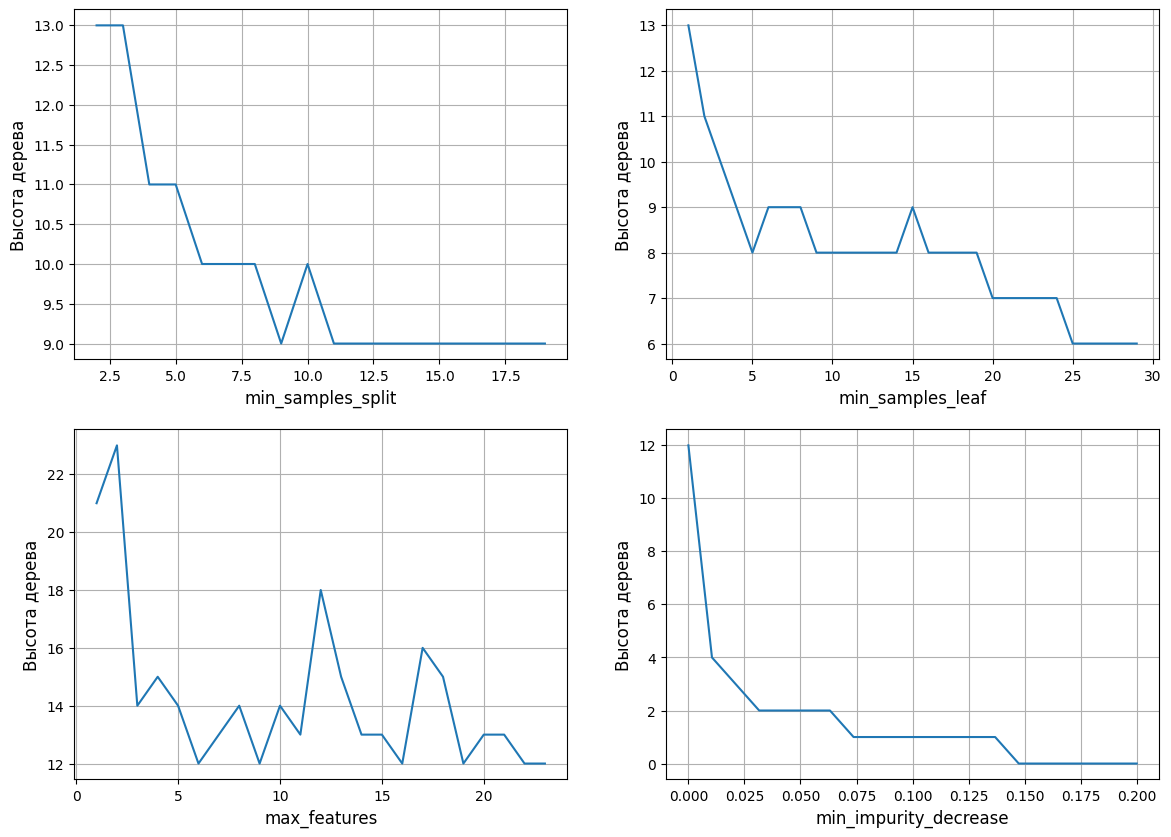

In [29]:
param_values = {
    "min_samples_split": range(2, 20),
    "min_samples_leaf": range(1, 30),
    "max_features": range(1, X_train.shape[1] + 1),
    "min_impurity_decrease": np.linspace(0, 0.2, 20)
}

hyperparameters = ["min_samples_split", "min_samples_leaf", "max_features", "min_impurity_decrease"]

plot_max_depth_on_hyperparameter(DecisionTreeClassifier, X_train, Y_train, hyperparameters, param_values)

## Высота дерева для моей реализации

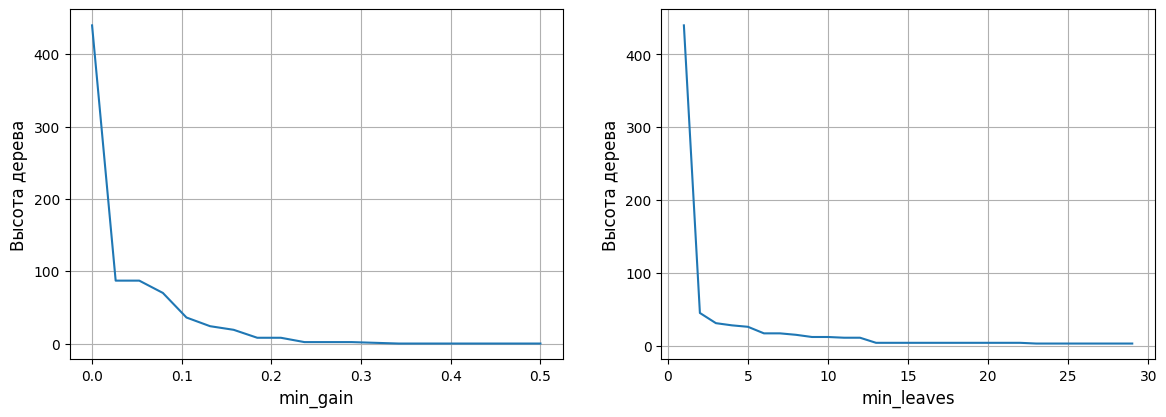

In [36]:
hyperparameters = ["min_gain", "min_leaves"]

param_values = {
    "min_leaves": range(1, 30),
    "min_gain": np.linspace(0, 0.5, 20)
}
plot_max_depth_on_hyperparameter(DecisionTree, X_train.to_numpy(), Y_train.to_numpy(), hyperparameters, param_values)

## Функция качества от высоты дерева (Дерево решений)

In [44]:
def plot_train_test_accuracy(model, param, param_values, X_train, Y_train, X_test, Y_test, title):
    train = []
    test = []
    for i in tqdm(param_values):
        curr_param = {param: i}
        tree = model(**curr_param)
        tree.fit(X_train, Y_train)

        y_pred = tree.predict(X_train)
        accuracy = accuracy_score(np.array(y_pred), Y_train)
        train.append(accuracy)

        y_pred = tree.predict(X_test)
        accuracy = accuracy_score(np.array(y_pred), Y_test)
        test.append(accuracy)

    plt.figure(figsize=(7, 5))
    plt.plot(param_values, train, label="train")
    plt.plot(param_values, test, label="test")
    plt.title(title, fontsize=14)
    plt.xlabel(param, fontsize=12)
    plt.ylabel("accuracy_score", fontsize=12)
    plt.legend()

    plt.show()

100%|██████████| 99/99 [00:01<00:00, 95.28it/s]


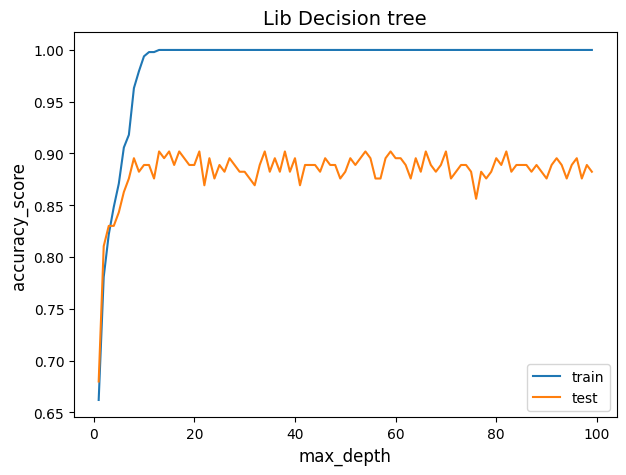

100%|██████████| 99/99 [00:19<00:00,  5.03it/s]


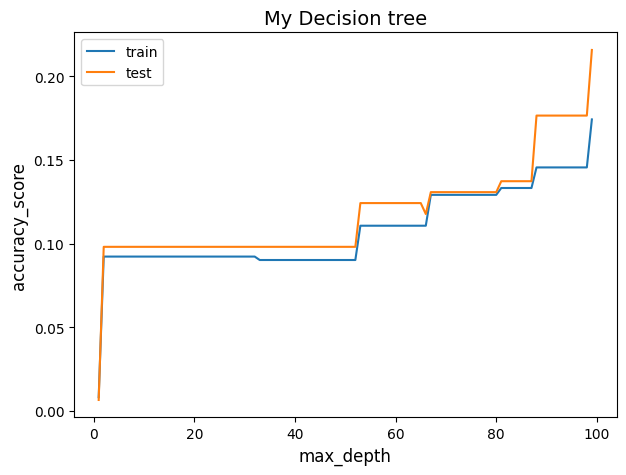

In [45]:
plot_train_test_accuracy(DecisionTreeClassifier, "max_depth", range(1, 100), X_train, Y_train, X_test, Y_test,
                         "Lib Decision tree")

plot_train_test_accuracy(DecisionTree, "max_depth", range(1, 100), X_train.to_numpy(), Y_train.to_numpy(), X_test.to_numpy(), Y_test.to_numpy(),
                         "My Decision tree")

## Функция качества от количества деревьев (Рандомный лес)

100%|██████████| 99/99 [00:13<00:00,  7.56it/s]


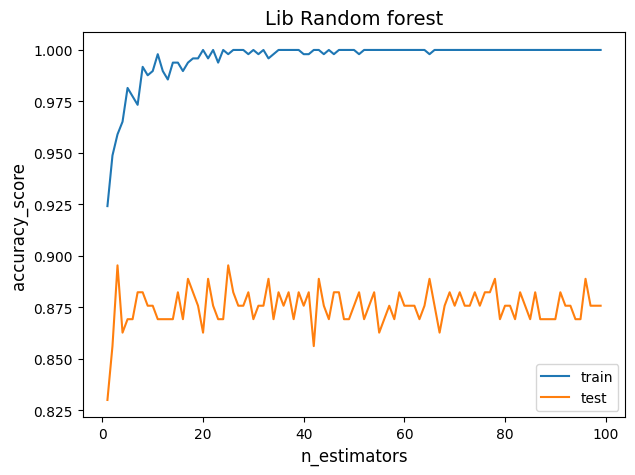

100%|██████████| 99/99 [12:26<00:00,  7.54s/it]


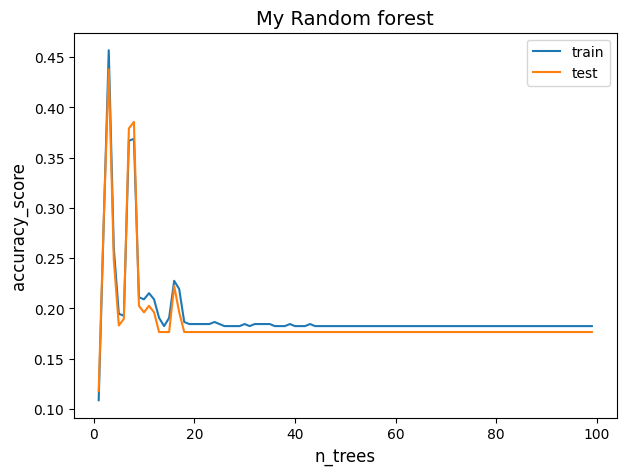

In [47]:
plot_train_test_accuracy(RandomForestClassifier, "n_estimators", range(1, 100), X_train, Y_train, X_test, Y_test,
                         "Lib Random forest")

plot_train_test_accuracy(RandomForest, "n_trees", range(1, 100), X_train.to_numpy(), Y_train.to_numpy(), X_test.to_numpy(), Y_test.to_numpy(),
                         "My Random forest")

## График для бустинга

100%|██████████| 99/99 [00:44<00:00,  2.24it/s]


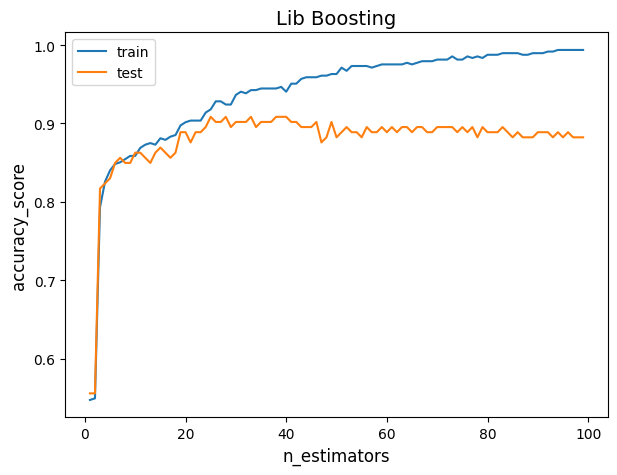

In [49]:
plot_train_test_accuracy(GradientBoostingClassifier, "n_estimators", range(1, 100), X_train.to_numpy(), Y_train.to_numpy(), X_test.to_numpy(), Y_test.to_numpy(),
                         "Lib Boosting")